In [ ]:
!pip install sentinelhub rasterio spectral -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 11.6 MB/s eta 0:00:00


In [ ]:
# Biblitoecas
import datetime
import numpy as np
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
    bbox_to_dimensions,
    SHConfig
)
import geopandas as gpd
import rasterio as rio
from rasterio.plot import reshape_as_image
from shapely.geometry import shape
from spectral import imshow
from getpass import getpass
import requests

In [ ]:
# Autenticação
config = SHConfig()
config.sh_client_id = getpass("Client-ID")
config.sh_client_secret = getpass("Client-secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

Client-ID··········
Client-secret··········


In [ ]:
# Defina as coordenadas da área de interesse
gdf = gpd.read_file("/content/DF.geojson")
bbox = shape(gdf.geometry[0]).bounds

resolution = 60  # Resolução desejada em metros

aoi_bbox = BBox(bbox=bbox, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Tamanho da imagem: {aoi_size} pixels")

In [ ]:
# Script  para baixar todas as bandas
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

Tamanho da imagem: (1733, 1035) pixels


In [ ]:
# Solicitação de dados Sentinel-2 L1C
request_all_bands = SentinelHubRequest(
    data_folder="/content",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2022-06-01", "2022-07-30"),  # Período de interesse
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

all_bands_img = request_all_bands.save_data()

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  (3, 2, 1)
  Interpolation       :  <default>
  RGB data limits     :
    R: [397.0, 2238.0]
    G: [610.0, 1612.0]
    B: [730.0, 1464.0]

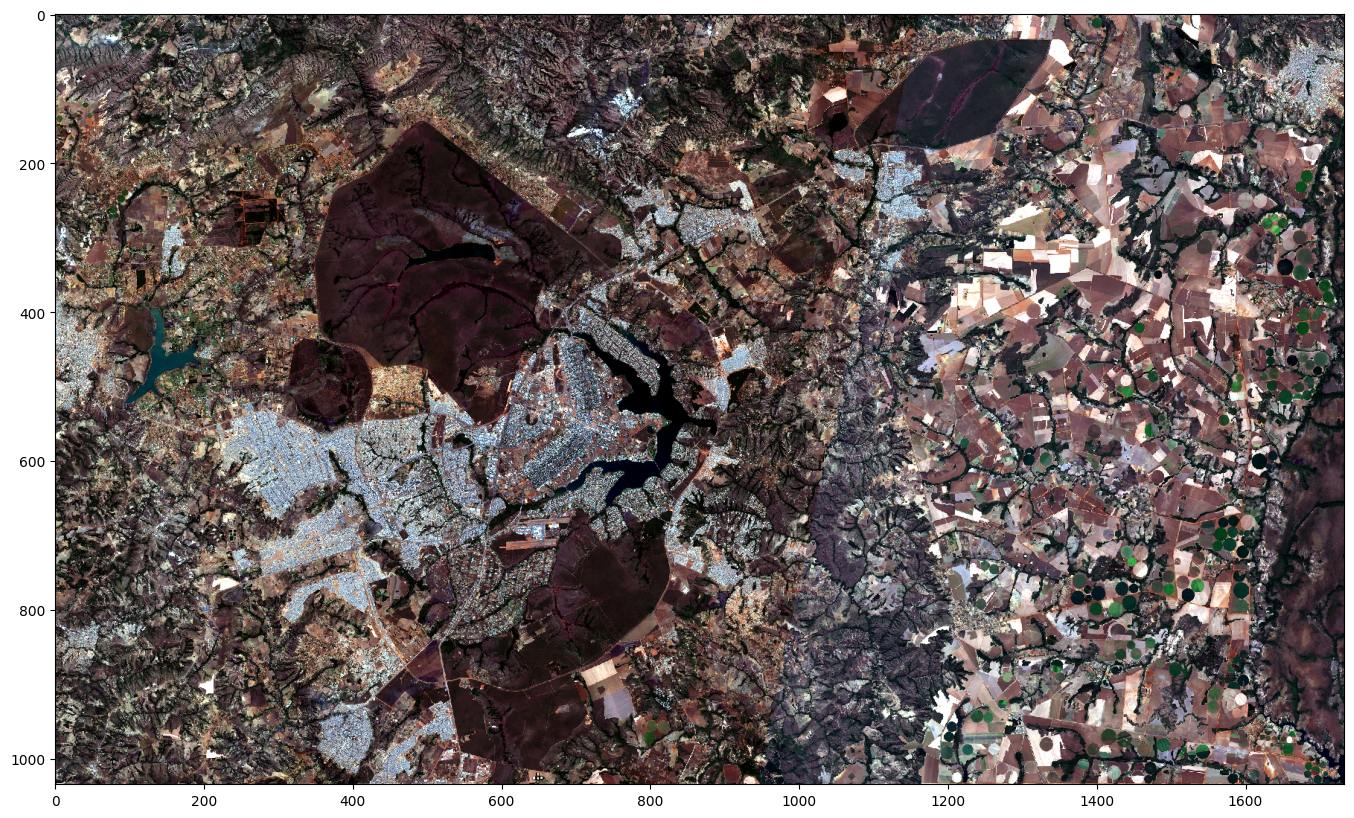

In [ ]:
# Lendo e visualizando arquivo
with rio.open("/content/b84ea03685d084277612561b6d2514bf/response.tiff") as src:
  img = reshape_as_image(src.read())

imshow(img, (3,2,1), stretch=(0.02,0.98), figsize=(20,10))